In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet

In [2]:
df = pd.read_csv('data/ghana_gdp.csv', parse_dates=['year'], index_col=['year'], dayfirst=True)
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


#### Построим график 

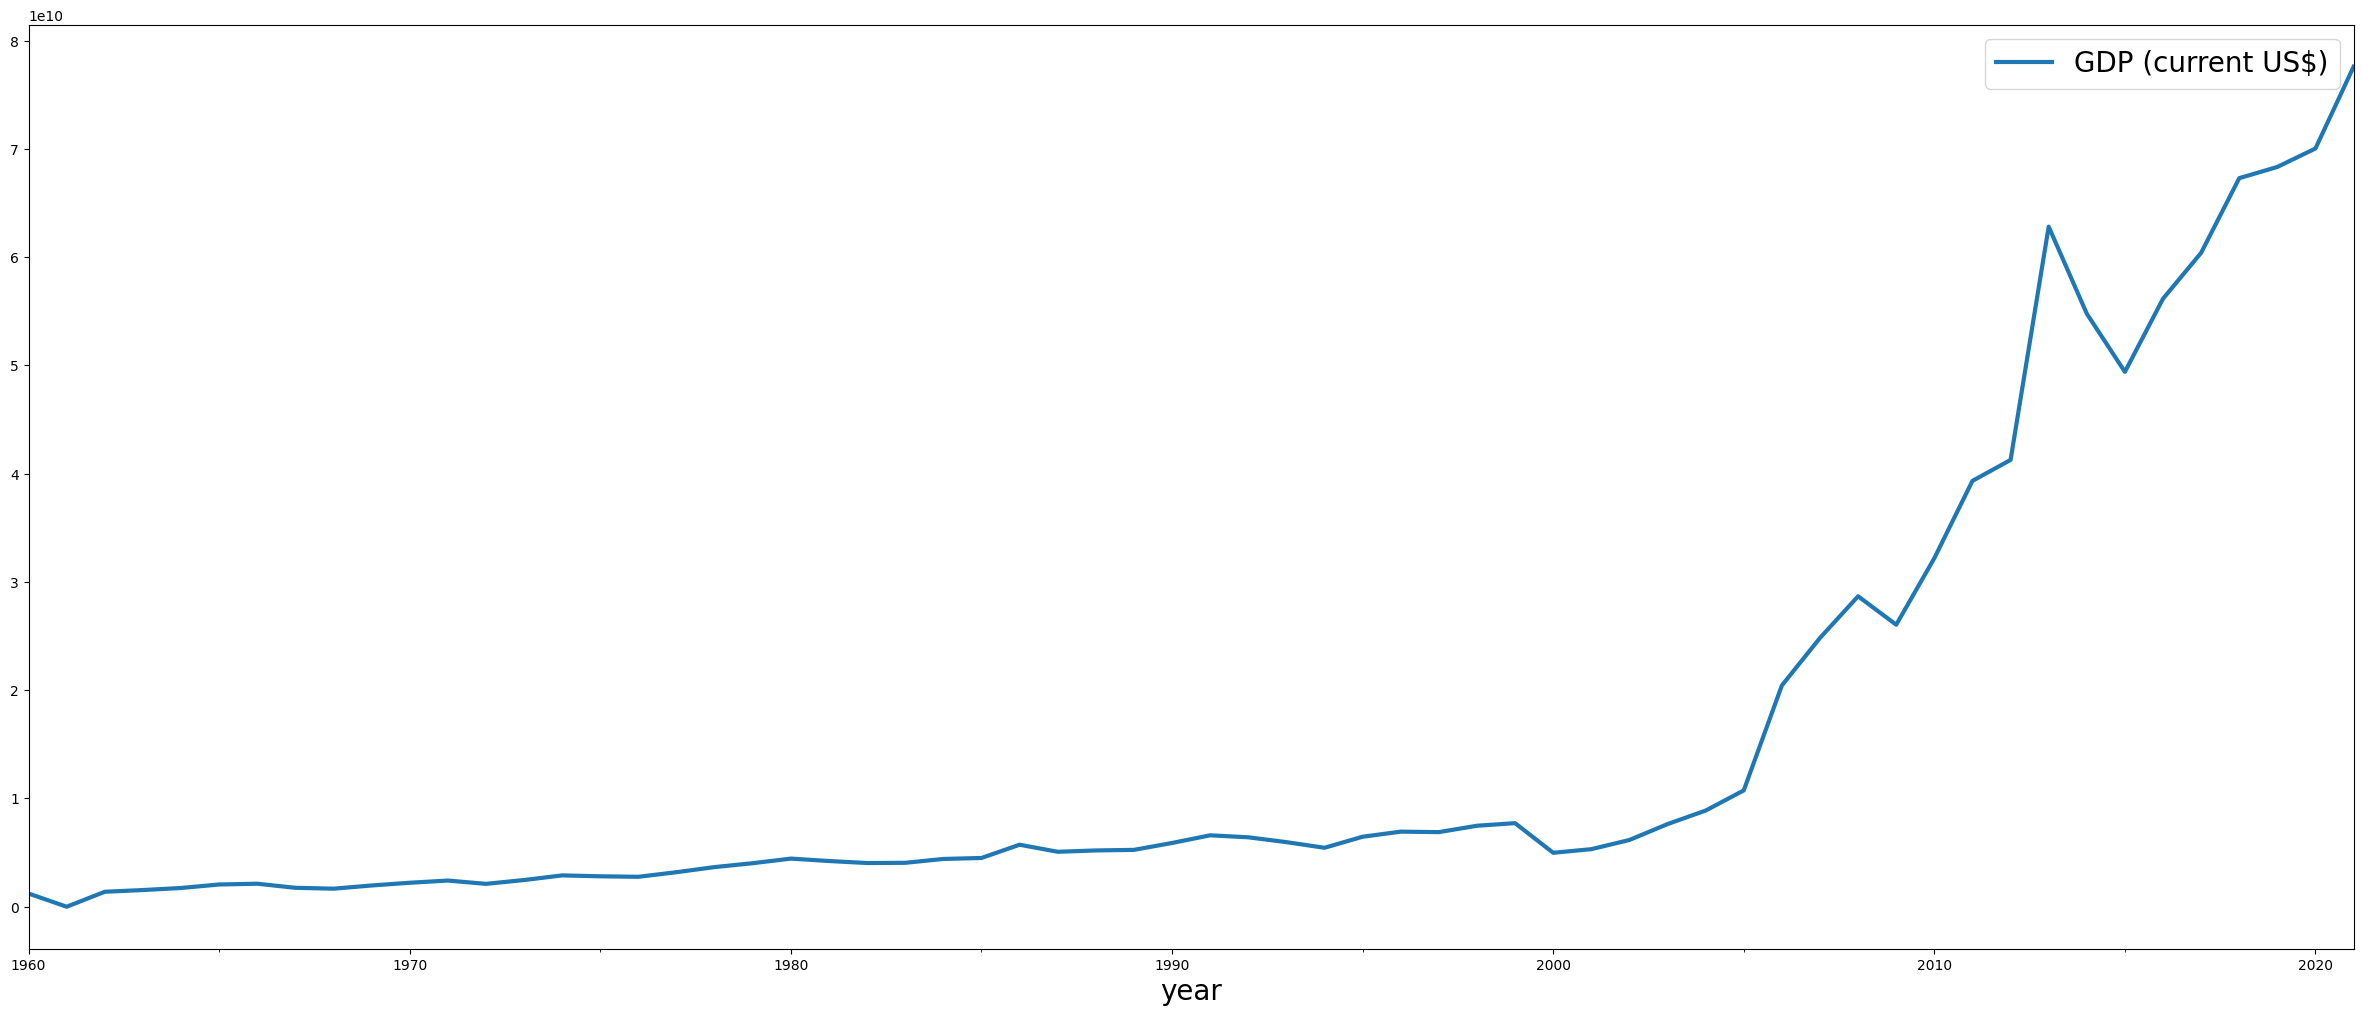

In [3]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

df.plot()
plt.show()

#### Вывод: На данном графике мы видим восходящий тренд ВВП в  долларовом эквиваленте 

#### Разделим данные на обучающую и тестовую выборки за последние 3 года 

In [4]:
train_df = df.iloc[:-4]
test_df = df.iloc[-4:]
train_df.shape, test_df.shape

((58, 1), (4, 1))

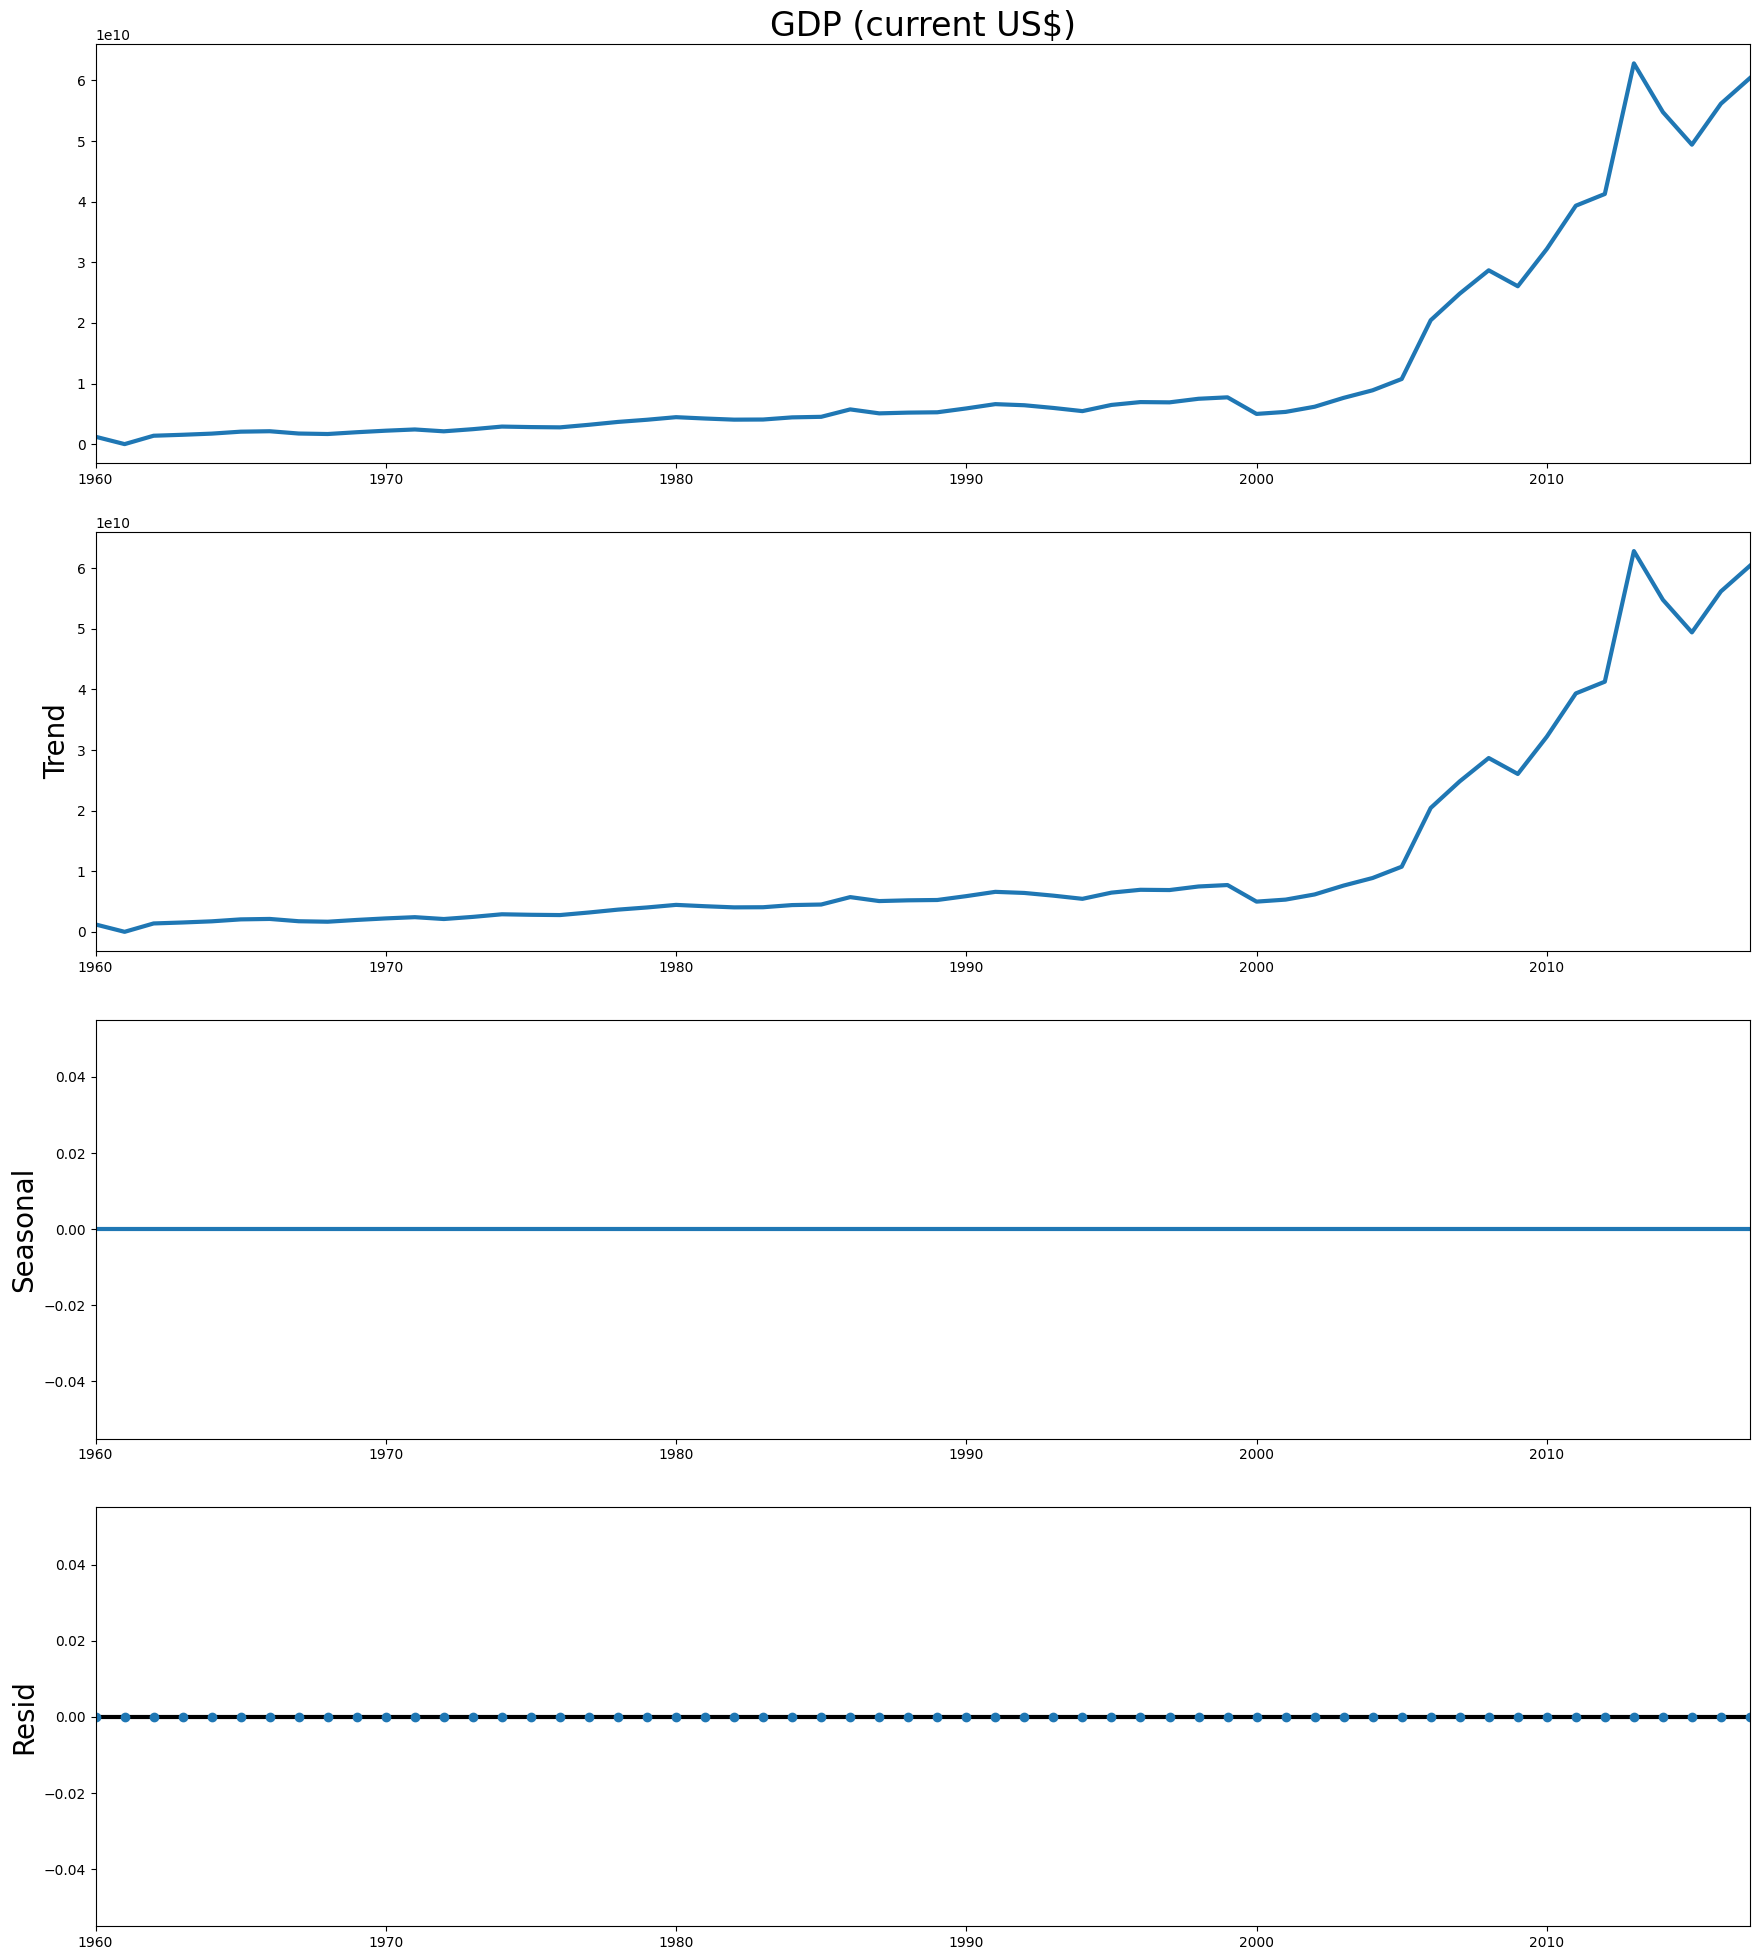

In [5]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df['GDP (current US$)'])
result.plot()
plt.show()

#### Вывод: Сезонности не наблюдается

#### Построение графика скользящего среднего

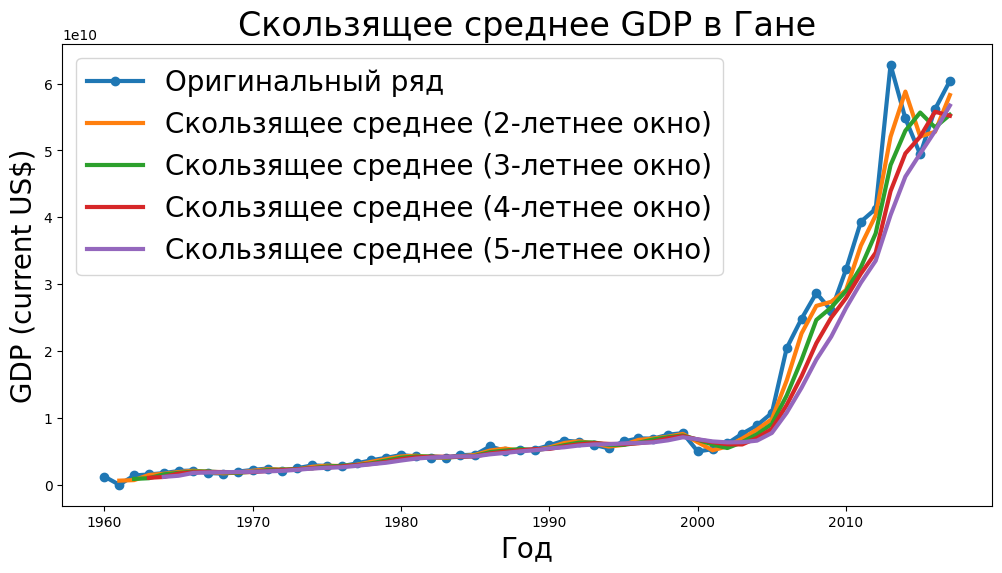

In [6]:
# Построение скользящего среднего с разными окнами
window_sizes = [2, 3, 4, 5]

plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['GDP (current US$)'], label='Оригинальный ряд', marker='o')

for window_size in window_sizes:
    rolling_mean = train_df['GDP (current US$)'].rolling(window=window_size).mean()
    plt.plot(train_df.index, rolling_mean, label=f'Скользящее среднее ({window_size}-летнее окно)')

plt.title('Скользящее среднее GDP в Гане')
plt.xlabel(xlabel = 'Год')
plt.ylabel(ylabel = 'GDP (current US$)')
plt.legend()
plt.show()

#### Вывод: Мы видим как оригинальный ряд  коррелирует со скользящими средними, чем меньше окно тем больше корреляция

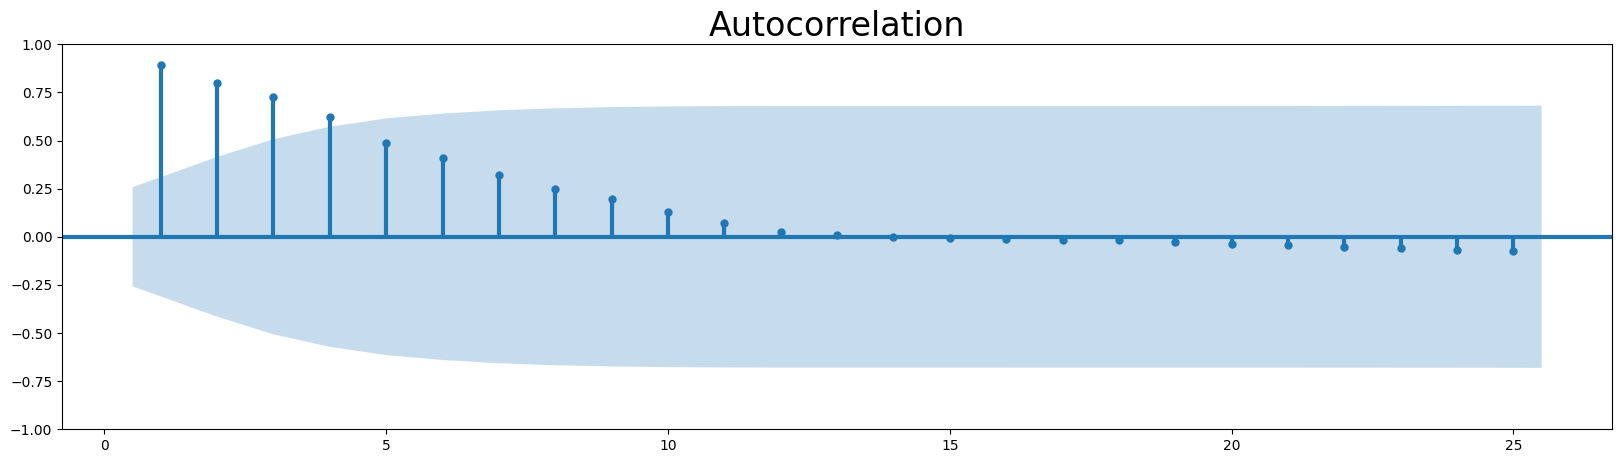

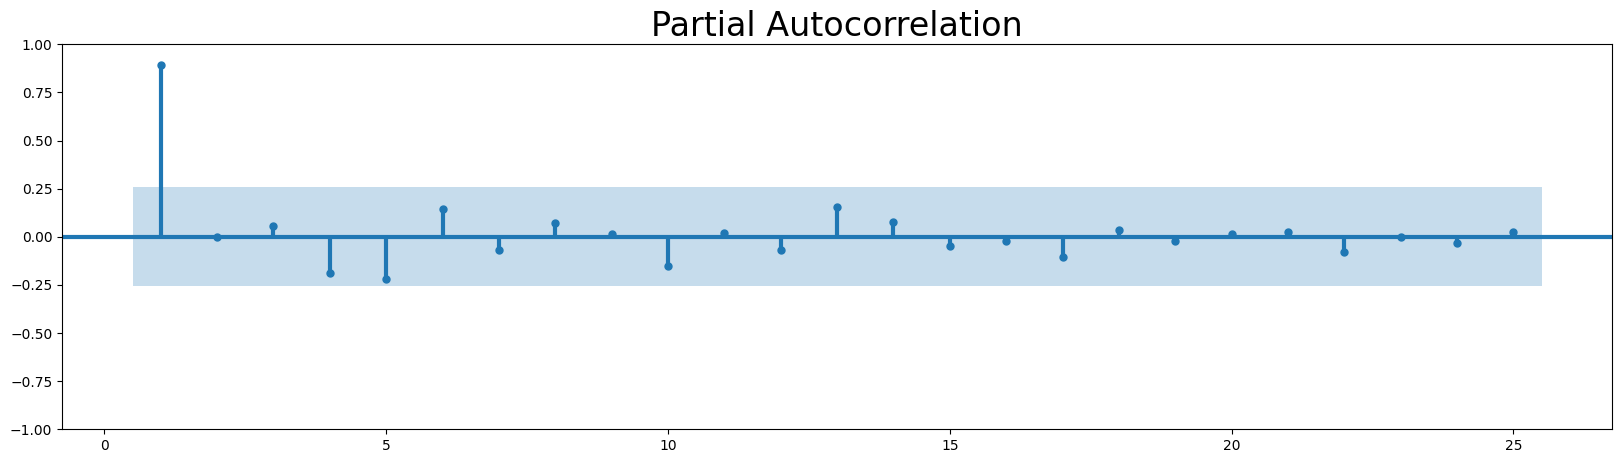

In [7]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df['GDP (current US$)'], lags=25, zero=False)
plt.show() 
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df['GDP (current US$)'], lags=25, method="ywm", zero=False)
plt.show()

#### Вывод:  Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя. На основе графика PACF лаги не приносят для нас новой информации, выбираем лаг равный 1 

#### Проверим данные на наличие пропущенных дат 

In [8]:
# Проверяем данные на наличие пропущенных дат 
df.asfreq(freq='AS') 

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [9]:
# Проверяем даты на пропущенные значения 
df.asfreq(freq='AS').isna().sum()

GDP (current US$)    0
dtype: int64

In [10]:
# Делаем проверку на наличие нулевых значений и в случае нахождения заменяем их на NaN
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

#### Проводим интерполяцию 

In [11]:
# Проводим интерполяцию 
df.interpolate(method='linear')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


#### Проведём  тест Дики-Фуллера

In [12]:

def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  0.5393306248349177
p-value:  0.9860207453998459
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


#### Дифференцирование ряда

In [13]:
# Если не стационарный ряд 
otg1diff = df.diff(periods=1).dropna()
otg1dif_new = otg1diff.diff(periods=1).dropna()
otg1dif_more = otg1dif_new.diff(periods=1).dropna()

In [14]:
stat_test(otg1dif_more)

adf:  -5.316127302818506
p-value:  5.0698087992428625e-06
Critical values:  {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}
единичных корней нет, ряд стационарен


#### Построим ещё раз коррелограммы на стационарном ряде

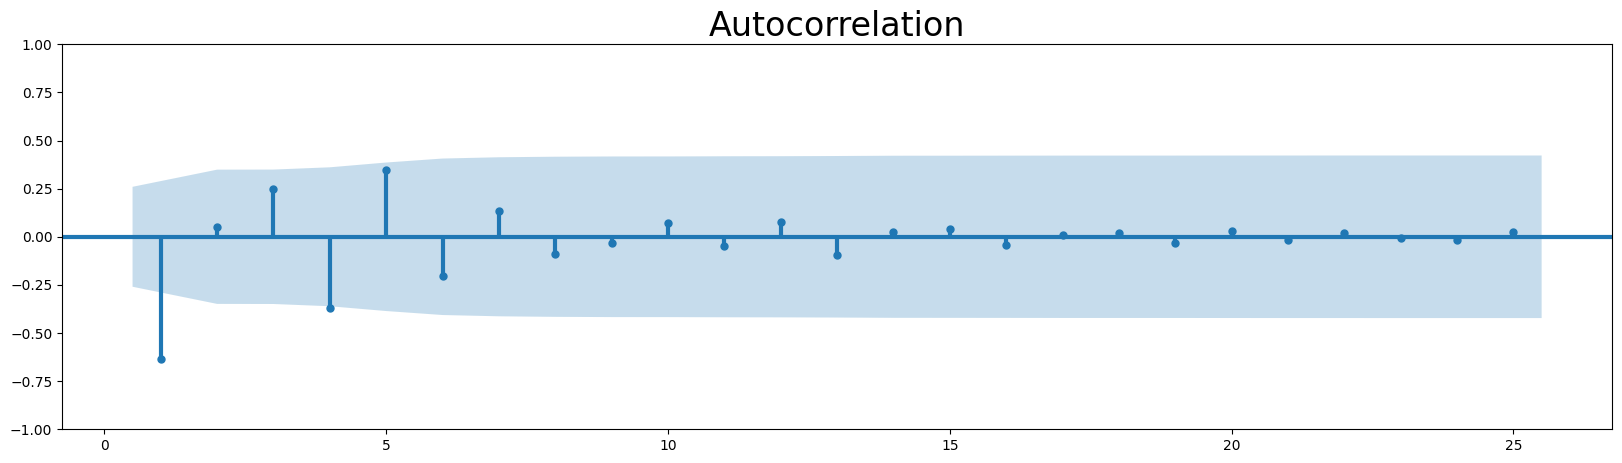

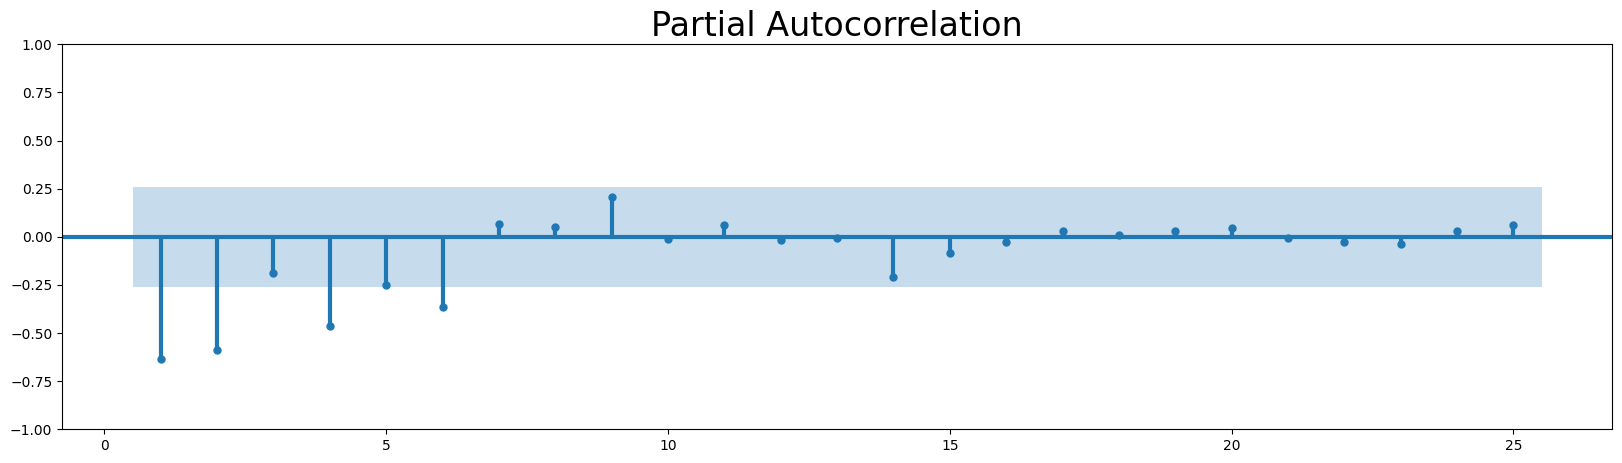

In [15]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(otg1dif_more['GDP (current US$)'], lags=25, zero=False)
plt.show() 
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(otg1dif_more['GDP (current US$)'], lags=25, method="ywm", zero=False)
plt.show()

#### Вывод: Тут мы уже можем видеть восходящий тренд, количество лагов =6 

#### 8.3 Выполним разбиение walk forward validation

In [16]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

train_test_groups = tscv.split(df['GDP (current US$)']) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


In [17]:
tscv = TimeSeriesSplit(max_train_size=df['GDP (current US$)'].count() -7)

train_test_groups = tscv.split(df['GDP (current US$)']) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 12 TEST size: 10
TRAIN size: 22 TEST size: 10
TRAIN size: 32 TEST size: 10
TRAIN size: 42 TEST size: 10
TRAIN size: 52 TEST size: 10


### Вывод: Получили множественное разбиение, так как объём обучающих выборок различен 

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 1 
- q = 1 

Если рассматривать сезонную модель (**SARMA**), то в модель можно добавить следующие параметры.

- m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
- P = 1 
- D = 1
- Q = 1 

In [18]:


arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(2, 1, 1), seasonal_order=(0, 1, 0, 5))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\Jowiry\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Jowiry\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Jowiry\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                GDP (current US$)   No. Observations:                   58
Model:             ARIMA(2, 1, 1)x(0, 1, [], 5)   Log Likelihood               -1213.381
Date:                          Tue, 26 Dec 2023   AIC                           2434.762
Time:                                  17:53:35   BIC                           2442.567
Sample:                              01-01-1960   HQIC                          2437.754
                                   - 01-01-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7640      0.112     -6.800      0.000      -0.984      -0.544
ar.L2         -0.2811      0.109     -2.585      0.010      -0.494      -0.068
ma.L1          0.8983      0.084     10.708      0.000       0.734       1.063
sigma2      1.228e+19   1.64e-21    7.5e+39      0.000    1.23e+19    1.23e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                45.70
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              23.09   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+56. Standard errors may be unstable.
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

#### Мы видим что показатели улучшились после добавления  значений в seasonal_order 

In [19]:
seas_model = SARIMAX(
    train_df['GDP (current US$)'].dropna(), order=(2, 2, 1), seasonal_order=(0, 1, 2, 5)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()


c:\Users\Jowiry\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Jowiry\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                      GDP (current US$)   No. Observations:                   58
Model:             SARIMAX(2, 2, 1)x(0, 1, [1, 2], 5)   Log Likelihood               -1192.723
Date:                                Tue, 26 Dec 2023   AIC                           2397.447
Time:                                        17:53:35   BIC                           2409.038
Sample:                                    01-01-1960   HQIC                          2401.876
                                         - 01-01-2017                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1044      0.272     -0.384      0.701      -0.637       0.428
ar.L2         -0.4098      0.206     -1.985      0.047      -0.814      -0.005
ma.L1         -0.9414      0.167     -5.634      0.000      -1.269      -0.614
ma.S.L5        0.1513      0.421      0.360      0.719      -0.673       0.976
ma.S.L10      -0.3154      0.701     -0.450      0.653      -1.689       1.058
sigma2      1.566e+19   5.83e-20   2.69e+38      0.000    1.57e+19    1.57e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               115.60
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):              67.30   Skew:                             1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+54. Standard errors may be unstable.
"""

In [20]:
df

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,NaN
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


#### 95% Доверительный интервал

In [21]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP (current US$)'] = df['GDP (current US$)']

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] =  forecast_df["upper GDP (current US$)"] 


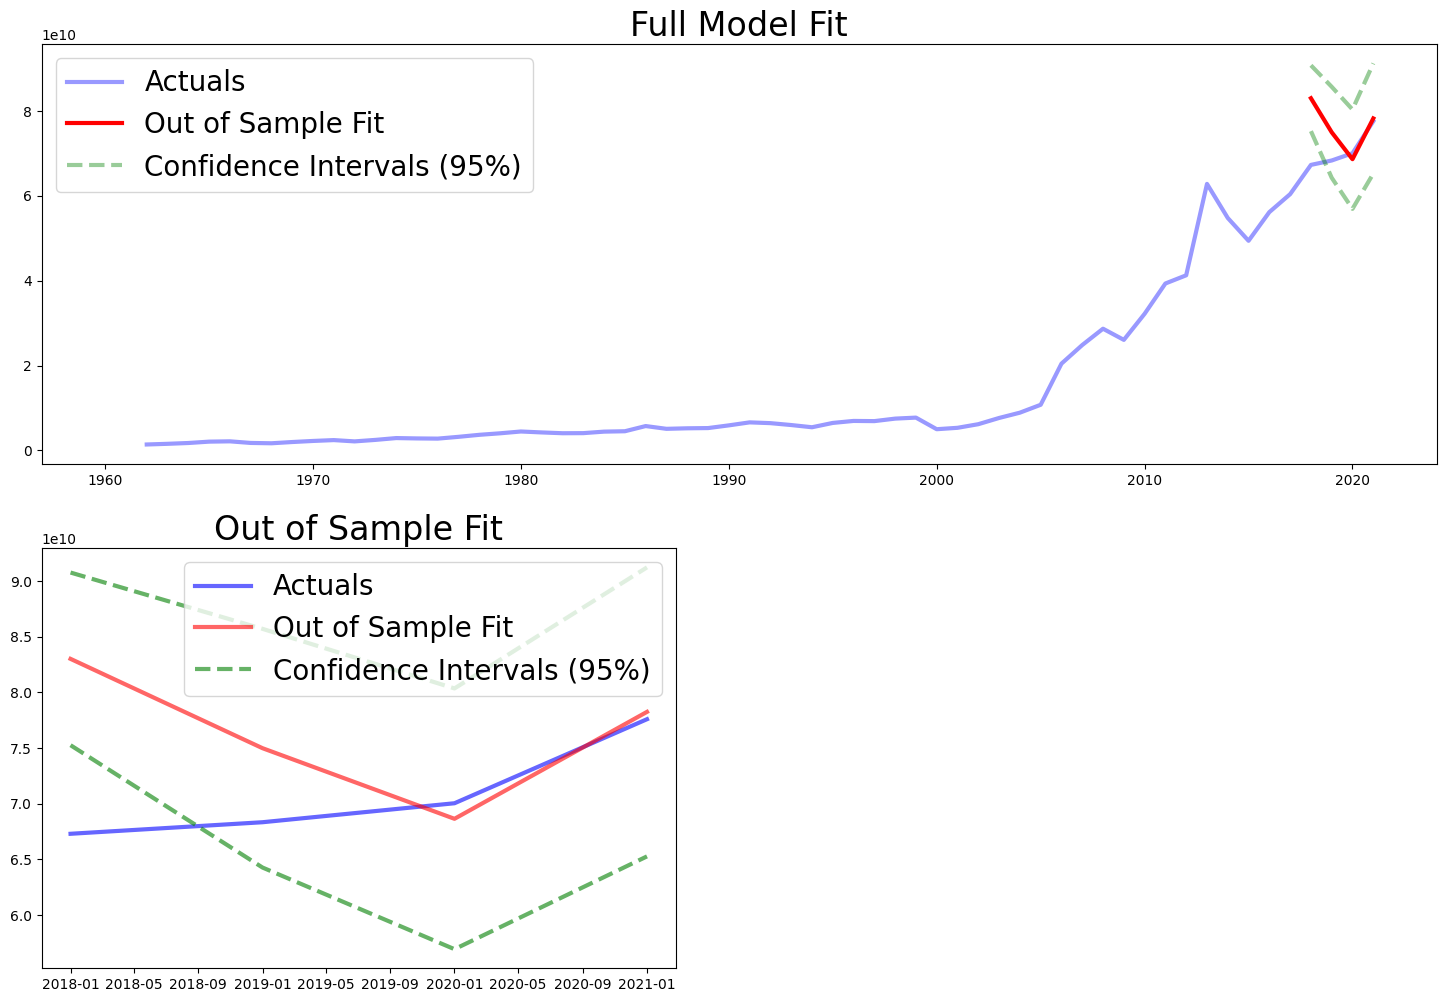

In [22]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df['GDP (current US$)'], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]['GDP (current US$)'], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [23]:
df

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,NaN
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


#### Подберём наилучшие параметры с помощью модели pmdarima

In [24]:

smodel = pm.auto_arima(
    train_df['GDP (current US$)'],
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2438.900, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2439.034, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2442.411, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2442.258, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=2436.962, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=2438.925, Time=0.07 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=2440.879, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=2440.743, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=2440.678, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=2434.762, Time=0.05 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=2436.560, Time=0.09 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2436.089, Time=0.09 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2437.706, Time=0.13 sec
 ARIMA(2,1,0)(0,1,0)[5]             : AIC=2437.060, Time=0.03 sec
 ARIMA(3,1,1)(0,1,0)[5]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   58
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 5)   Log Likelihood               -1213.381
Date:                            Tue, 26 Dec 2023   AIC                           2434.762
Time:                                    17:53:37   BIC                           2442.567
Sample:                                01-01-1960   HQIC                          2437.754
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7640      0.112     -6.800      0.000      -0.984      -0.544
ar.L2         -0.2811      0.109     -2.585      0.010      -0.494      -0.068
ma.L1          0.8983      0.084     10.708      0.000       0.734       1.063
sigma2      1.228e+19   1.64e-21    7.5e+39      0.000    1.23e+19    1.23e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                45.70
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              23.09   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+56. Standard errors may be unstable.
"""

## Волатильность 

In [25]:
df["spx_vol"] = (df['GDP (current US$)'] - df['GDP (current US$)'].shift(1))/df['GDP (current US$)'].shift(1)
df["spx_vol"] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df["spx_vol"].head()

year
1960-01-01          NaN
1961-01-01     0.000000
1962-01-01    13.578826
1963-01-01    11.448835
1964-01-01    12.363636
Name: spx_vol, dtype: float64

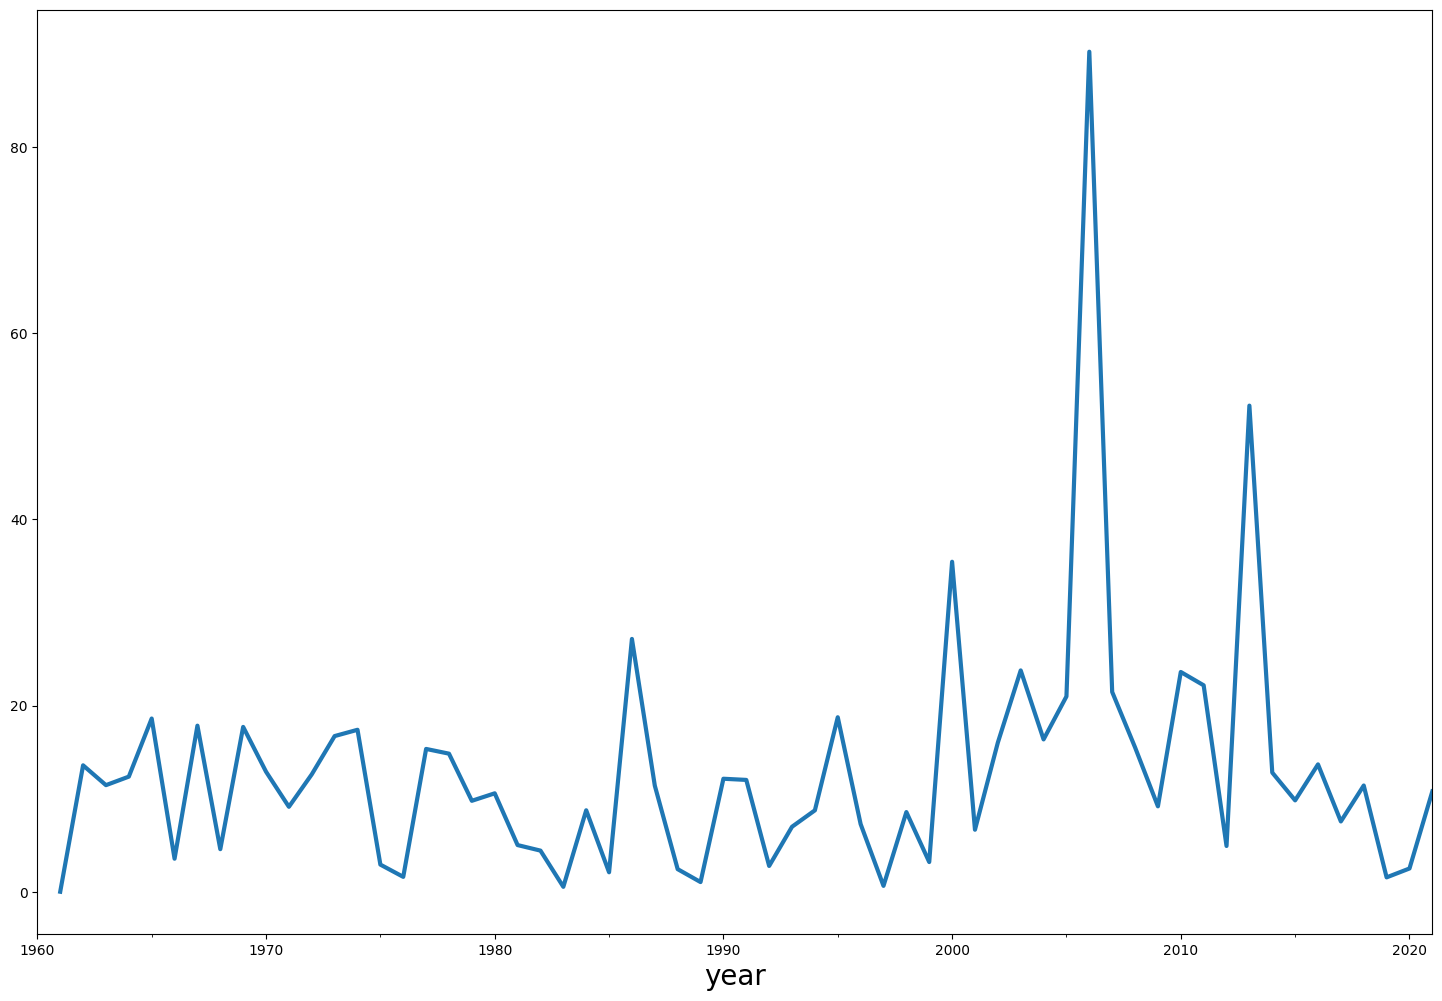

In [26]:
df['spx_vol'].plot()
plt.show()

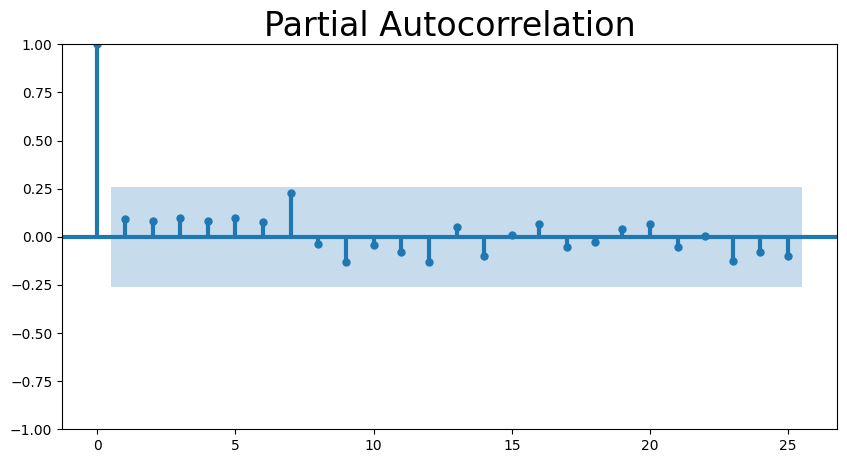

In [27]:
plt.rcParams["figure.figsize"] = 10, 5

train_df = df.iloc[:-4]
test_df = df.iloc[-4:]

sgt.plot_pacf(train_df['spx_vol'][1:], lags=25, method="ywm")
plt.show()

In [28]:
adfuller(train_df['spx_vol'][1:])

(-6.7508257816686195,
 2.9541610383588006e-09,
 0,
 56,
 {'1%': -3.552928203580539,
  '5%': -2.9147306250000002,
  '10%': -2.595137155612245},
 375.4784266194796)

Глядя на графики PACF для доходности и волатильности, становится ясно, что самый значтельный - 1 лаг, а затем уровни значимости значительно падают. Итак, мы построим модель GARCH(1, 2).

In [29]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(df['spx_vol'].loc[df.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, 'spx_vol' ] = train_df['spx_vol'].dropna()

In [30]:
from arch import arch_model

model = arch_model(garch_df['spx_vol'].dropna(), p=1, q=2)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     34,   Neg. LLF: 225.74059858789403
Iteration:     10,   Func. Count:     64,   Neg. LLF: 223.8412249748177
Iteration:     15,   Func. Count:     94,   Neg. LLF: 223.82971279197145
Iteration:     20,   Func. Count:    124,   Neg. LLF: 223.74760804027747
Optimization terminated successfully    (Exit mode 0)
            Current function value: 223.74715756040504
            Iterations: 24
            Function evaluations: 142
            Gradient evaluations: 23


In [31]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                spx_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -223.747
Distribution:                  Normal   AIC:                           457.494
Method:            Maximum Likelihood   BIC:                           467.710
                                        No. Observations:                   57
Date:                Tue, Dec 26 2023   Df Residuals:                       56
Time:                        17:53:38   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3649      2.692      4.594  4.358e-06 [  7.089, 17.641]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6898     17.544      0.210      0.833 [-30.695, 38.075]
alpha[1]       0.0000      0.132      0.000      1.000 [ -0.259,  0.259]
beta[1]        1.0000      0.857      1.167      0.243 [ -0.679,  2.679]
beta[2]    1.4629e-10      0.829  1.764e-10      1.000 [ -1.625,  1.625]
========================================================================

Covariance estimator: robust
"""

In [32]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

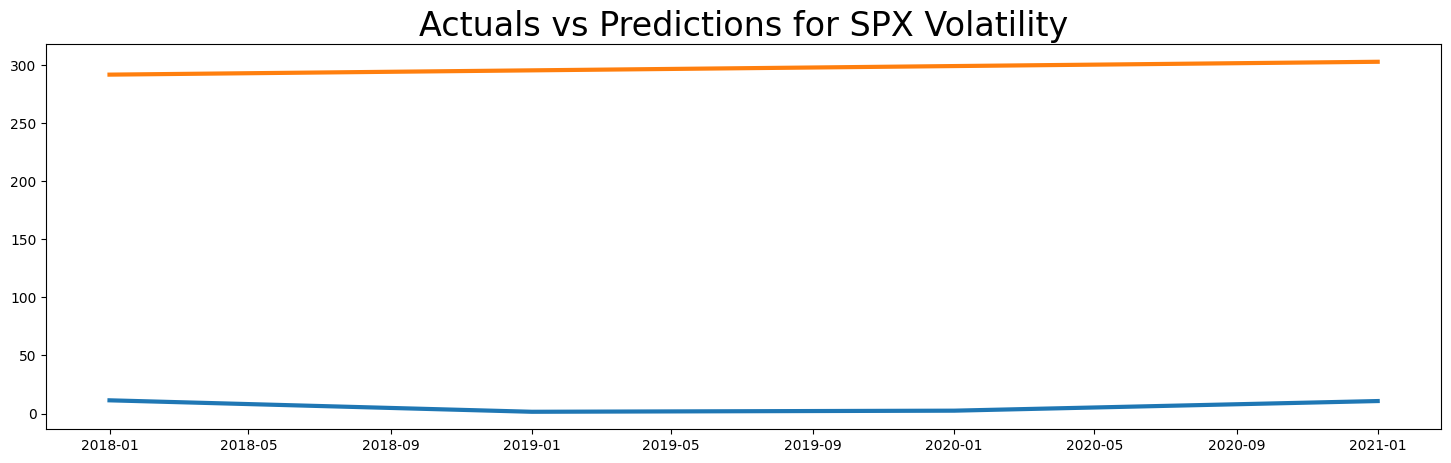

In [33]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df['spx_vol'].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

In [34]:
mean_squared_error(
    predictions_df['spx_vol'].abs(), predictions_df["Predictions"]
)

84592.74481235261

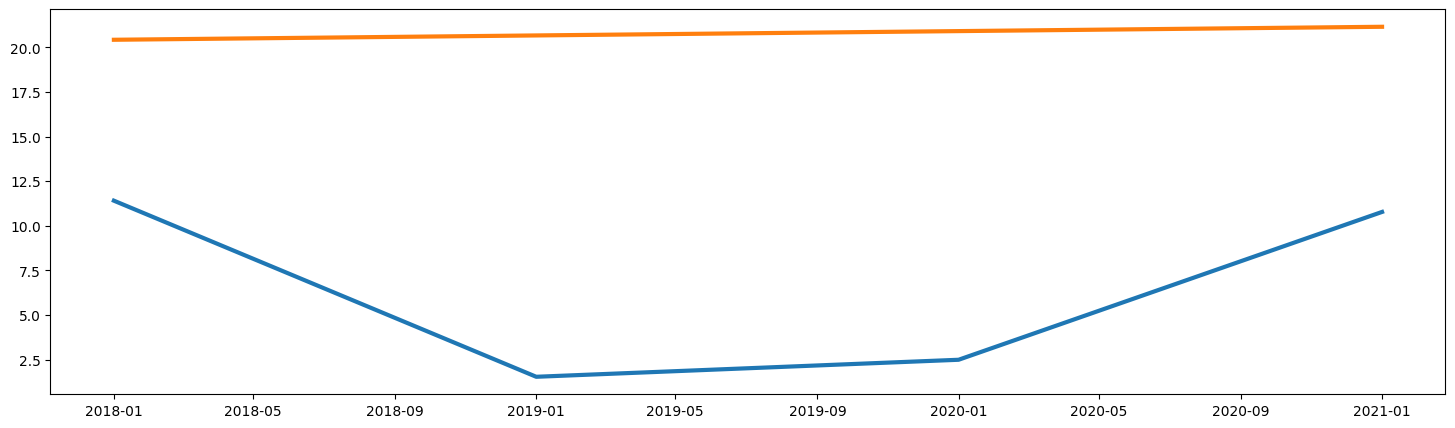

In [35]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(df['spx_vol'].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df['spx_vol'].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df['spx_vol'].fillna(0)
y_test = test_df['spx_vol'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

#### Вывод: Мы видим что модель линейной регрессии не справляется, она не уловила дисперсию 

#### PROPHET 

In [36]:
df

,GDP (current US$),spx_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,NaN,0.000000
1962-01-01,1.382353e+09,13.578826
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
...,...,...
2017-01-01,6.040638e+10,7.551317
2018-01-01,6.729928e+10,11.410877
2019-01-01,6.833754e+10,1.542746


In [37]:
# Создание модели
model = Prophet()

# Обучение модели
model.fit(train_df.reset_index().rename(columns={'year': 'ds', 'GDP (current US$)': 'y'}))

# Делаем прогноз для всей тестовой выборки
future = model.make_future_dataframe(periods=len(test_df))

# Прогноз
forecast = model.predict(future)

# Вывод результатов
print(forecast[['ds', 'yhat']].tail())

17:53:39 - cmdstanpy - INFO - Chain [1] start processing
17:53:39 - cmdstanpy - INFO - Chain [1] done processing


           ds          yhat
56 2017-01-01  3.372137e+10
57 2017-01-02  3.630983e+10
58 2017-01-03  4.130128e+10
59 2017-01-04  4.856173e+10
60 2017-01-05  5.789456e+10


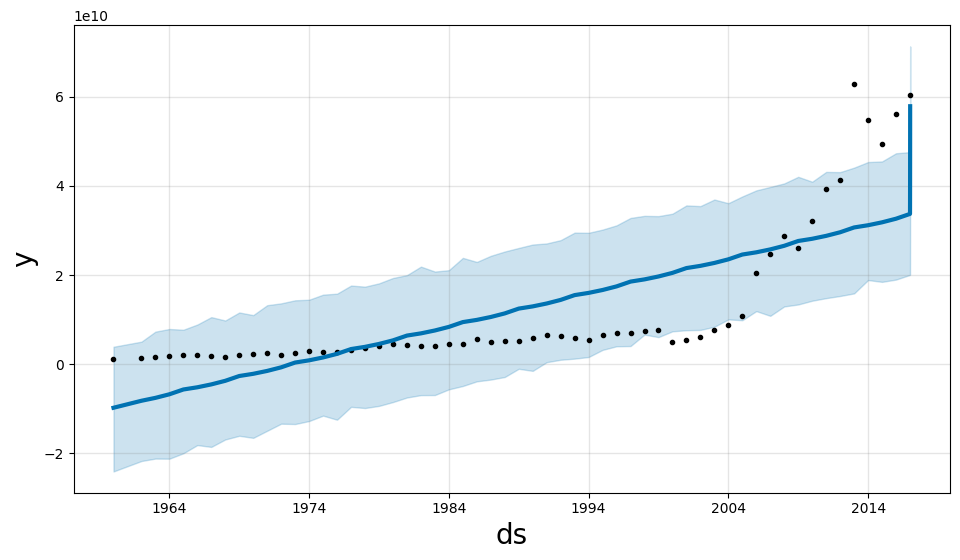

In [38]:
fig = model.plot(forecast)

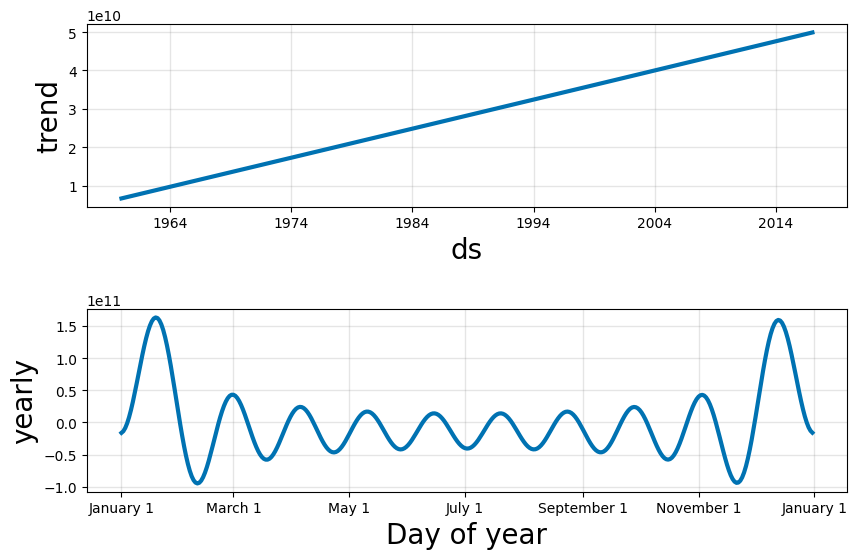

In [39]:
fig = model.plot_components(forecast)

In [40]:
# Извлечение фактических значений из тестовой выборки
y_true = test_df['GDP (current US$)'].values

# Извлечение предсказанных значений из прогноза
y_pred = forecast['yhat'].iloc[-4:].values

# Вычисление MSE
mse = mean_squared_error(y_true, y_pred)

# Вывод результата
print(f'Mean Squared Error (MSE): {mse}')


Mean Squared Error (MSE): 6.352093778481059e+20


#### Вывод:  модель ошибается на 6.35 % 

#### Сравнение предсказаний

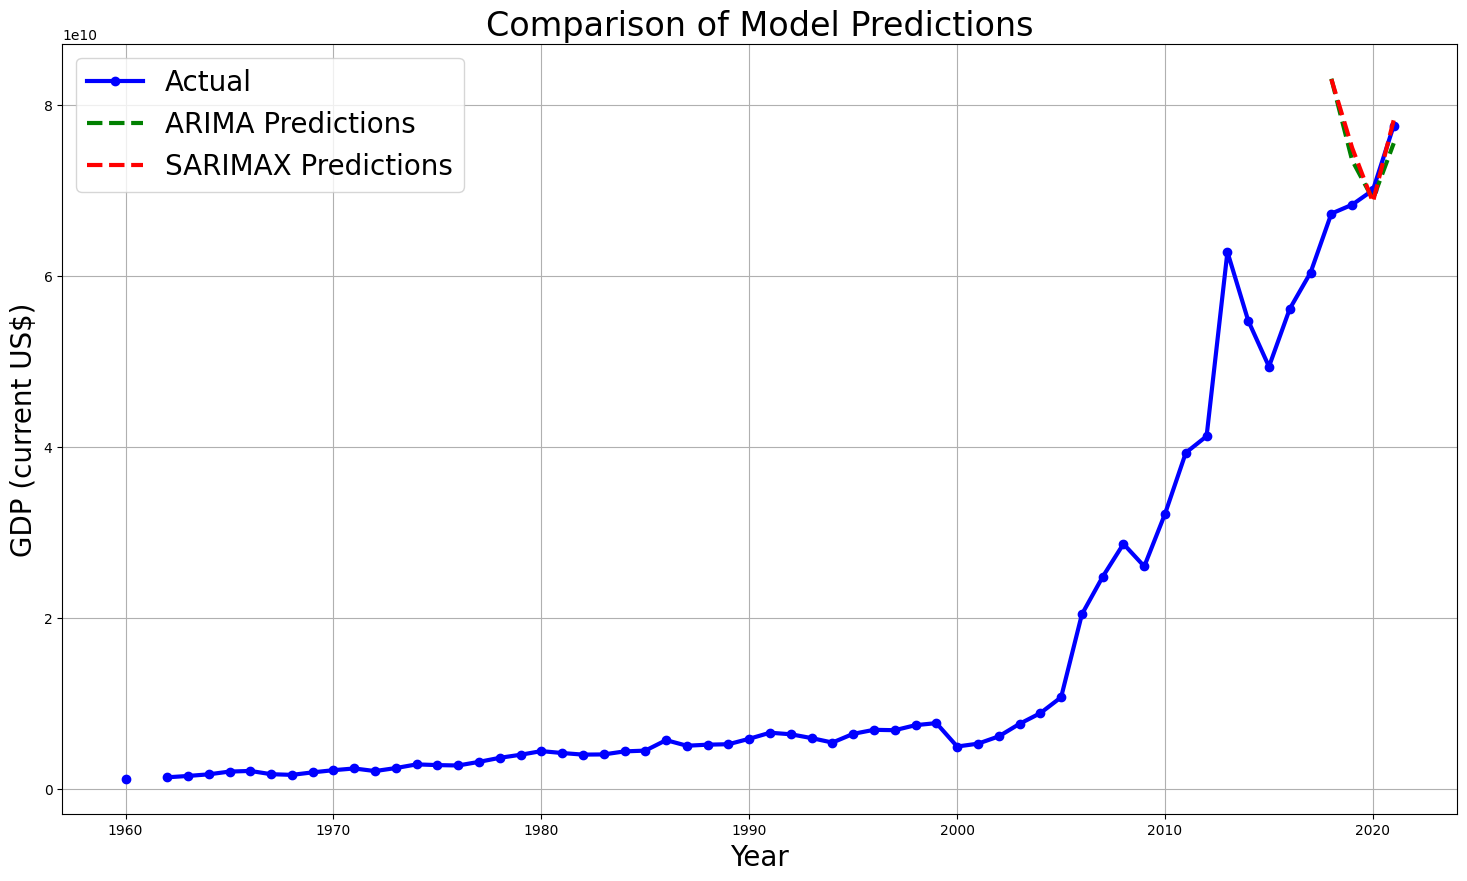

In [41]:
# Создание DataFrame для сравнения предсказаний
compare_df = pd.DataFrame(index=df.index)
compare_df['Actual'] = df['GDP (current US$)']
compare_df['ARIMA_Predictions'] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
compare_df['SARIMAX_Predictions'] = seas_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])

# Построение графика для сравнения
plt.figure(figsize=(18, 10))
plt.plot(compare_df.index, compare_df['Actual'], label='Actual', color='blue', marker='o')
plt.plot(compare_df.index, compare_df['ARIMA_Predictions'], label='ARIMA Predictions', color='green', linestyle='--')
plt.plot(compare_df.index, compare_df['SARIMAX_Predictions'], label='SARIMAX Predictions', color='red', linestyle='--')

plt.title('Comparison of Model Predictions')
plt.xlabel('Year')
plt.ylabel('GDP (current US$)')
plt.legend()
plt.grid(True)
plt.show()


#### Вывод: Мы можем видеть что лучшей моделью является ARIMA, так как она учитывает спуски, лучше всего подстраивается к графику

#### Сделаем предсказание и  узнаем какая модель лучше 

In [42]:
arima_model_fit_pred = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1], dynamic=False)
seas_model_fit_pred = seas_model_fit.predict(start=test_df.index[0], end=test_df.index[-1], dynamic=False)

mse_arima = mean_squared_error(test_df['GDP (current US$)'], arima_model_fit_pred)
mse_sarimax = mean_squared_error(test_df['GDP (current US$)'], seas_model_fit_pred)

print(f"MSE for ARIMA model: {mse_arima}")
print(f"MSE for Seasonal SARIMAX model: {mse_sarimax}")

# Сравнение MSE значений
if mse_arima < mse_sarimax:
    print("ARIMA model has a lower MSE.")
else:
    print("Seasonal SARIMAX model has a lower MSE.")

MSE for ARIMA model: 7.029080780004645e+19
MSE for Seasonal SARIMAX model: 7.3411086520009925e+19
ARIMA model has a lower MSE.


#### Вывод для модели GARCH: Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке.

#### Вывод общий: ошибка в модели ARIMA меньше, следовательно она лучше показывает результат и подходит для данной задачи, хотя мы видим на графике что результаты практически одинаковые 

#### Вывод 2:  Мы видим также что AIC критерий модели ARIMA, не изменился  по сравнению с моделью на неинтерполированных данных.